<a href="https://colab.research.google.com/github/jiiinchoi/MAI-Lab./blob/main/IMDB_movie_reviews_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 영화평 Text 분류 - Sentiment Analysis



## imdb_reviews (string data) 이용

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# 시드 설정
seed_value = 42
tf.random.set_seed(seed_value)

In [2]:
# 'imdb_reviews' 데이터셋을 로드하고, 정보(info)와 함께 로드 (as_supervised=True는 (input, label) 쌍으로 로드)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# 데이터셋을 훈련용(train)과 테스트용(test)으로 분할
train_dataset, test_dataset = dataset['train'], dataset['test']

# 데이터셋 및 정보 출력
print(info)
print()
print(train_dataset)
print()
print(test_dataset)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.D4EQYH_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.D4EQYH_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.D4EQYH_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
   

In [3]:
len(train_dataset), len(test_dataset)

(25000, 25000)

### tfds 는 tf.Tensor 반환

In [4]:
# 'test' 데이터셋의 각 (input, label) 쌍에 대해 반복
for input, label in dataset['test']:
    print(label)   # 레이블 출력 (리뷰의 긍정/부정 라벨)
    print(input)   # 입력 데이터 출력 (리뷰 텍스트)
    break

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), 

## keras.preprocessing module 을 이용하여 tokenize 및 padding


In [5]:
# 훈련용 문장과 레이블을 저장할 리스트 초기화
train_sentences = []
train_labels = []

# 테스트용 문장과 레이블을 저장할 리스트 초기화
test_sentences = []
test_labels = []

# 훈련 데이터셋의 각 (문장, 레이블) 쌍에 대해 반복
for sent, label in train_dataset:
    train_sentences.append(str(sent.numpy()))    # 문장을 문자열로 변환하여 리스트에 추가
    train_labels.append(label.numpy())    # 레이블을 numpy 형식으로 변환하여 리스트에 추가

# 테스트 데이터셋의 각 (문장, 레이블) 쌍에 대해 반복
for sent, label in test_dataset:
    test_sentences.append(str(sent.numpy()))     # 문장을 문자열로 변환하여 리스트에 추가
    test_labels.append(label.numpy())     # 레이블을 numpy 형식으로 변환하여 리스트에 추가

print(train_labels[-1])   # 훈련 데이터셋의 마지막 레이블 출력
print(train_sentences[-1])    # 훈련 데이터셋의 마지막 문장 출력

print(test_labels[-1])    # 테스트 데이터셋의 마지막 레이블 출력
print(test_sentences[-1])    # 테스트 데이터셋의 마지막 문장 출력

1
b'First of all, Riget is wonderful. Good comedy and mystery thriller at the same time. Nice combination of strange \'dogma\' style of telling the story together with good music and great actors. But unfortunately there\'s no \'the end\'. As for me it\'s unacceptable. I was thinking... how it will be possible to continue the story without Helmer and Drusse? ...and I have some idea. I think Lars should make RIGET III a little bit different. I\'m sure that 3rd part without Helmer wouldn\'t be the same. So here\'s my suggestion. Mayble little bit stupid, maybe not. I know that Lars likes to experiment. So why not to make small experiment with Riget3? I think the only solution here is to create puppet-driven animation (like for example "team America" by Trey Parker) or even computer 3d animation. I know it\'s not the same as real actors, but in principle I believe it could work... only this way it\'s possible to make actors alive again. For Riget fans this shouldn\'t be so big difference 

## train_labels, test_labels  list를 numpy array 로 변환

In [6]:
train_labels = np.array(train_labels)   # 훈련 레이블을 numpy 배열로 변환
test_labels = np.array(test_labels)    # 테스트 레이블을 numpy 배열로 변환

print(train_labels.shape)        # 훈련 레이블 배열의 형태 출력
print(test_labels.shape)         # 테스트 레이블 배열의 형태 출력

(25000,)
(25000,)


## train_sentences, test_sentences text 를 sequence 로 변환

In [7]:
# 사용할 단어 수의 최대 크기 설정
vocab_size = 10000

# Tokenizer 객체 생성 (최대 단어 수 지정 및 OOV(Out-Of-Vocabulary) 토큰 설정)
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

# 훈련 문장에 대해 토크나이저 학습 수행 (단어 인덱스 구축)
tokenizer.fit_on_texts(train_sentences)

In [8]:
# 훈련 문장들을 시퀀스로 변환
train_sequences = tokenizer.texts_to_sequences(train_sentences)

# 테스트 문장들을 시퀀스로 변환
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# 첫 번째 훈련 시퀀스 출력
print(train_sequences[0])

# 첫 번째 테스트 시퀀스 출력
print(test_sequences[0])

[59, 12, 14, 35, 439, 400, 18, 174, 29, 1, 9, 33, 1378, 3401, 42, 496, 1, 197, 25, 88, 156, 19, 12, 211, 340, 29, 70, 248, 213, 9, 486, 62, 70, 88, 116, 99, 24, 5740, 12, 3317, 657, 777, 12, 18, 7, 35, 406, 8228, 178, 2477, 426, 2, 92, 1253, 140, 72, 149, 55, 2, 1, 7525, 72, 229, 70, 2962, 16, 1, 2880, 1, 1, 1506, 4998, 3, 40, 3947, 119, 1608, 17, 3401, 14, 163, 19, 4, 1253, 927, 7986, 9, 4, 18, 13, 14, 4200, 5, 102, 148, 1237, 11, 240, 692, 13, 44, 25, 101, 39, 12, 7232, 1, 39, 1378, 1, 52, 409, 11, 99, 1214, 874, 145, 10]
[59, 44, 25, 109, 13, 97, 4115, 16, 742, 4370, 10, 14, 316, 5, 2, 593, 354, 16, 1864, 1212, 1, 16, 680, 7499, 5595, 1, 773, 6, 13, 1037, 1, 1, 439, 491, 1, 4, 1, 334, 3610, 20, 229, 3, 15, 5796, 3, 15, 1646, 15, 102, 5, 2, 3597, 101, 11, 1450, 1528, 12, 251, 235, 11, 216, 2, 377, 6429, 3, 62, 95, 11, 174, 105, 11, 1528, 180, 12, 251, 37, 6, 1144, 1, 682, 7, 4452, 1, 4, 1, 334, 7, 37, 8367, 377, 5, 1420, 1, 13, 30, 64, 28, 6, 874, 181, 17, 4, 1050, 5, 12, 224, 3, 83,

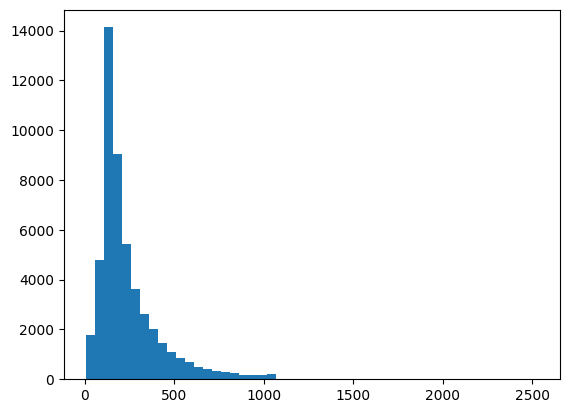

In [9]:
# 훈련 시퀀스와 테스트 시퀀스의 길이를 리스트로 변환하여 합친 후 히스토그램으로 시각화
plt.hist([len(s) for s in train_sequences] + [len(s) for s in test_sequences], bins=50);

In [10]:
max_length = 150

# 훈련 시퀀스를 패딩 처리 (최대 길이를 150으로 설정, 'post' 방식으로 잘라내고 패딩)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating='post', padding='post')

# 테스트 시퀀스를 패딩 처리 (최대 길이를 150으로 설정, 'post' 방식으로 잘라내고 패딩)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating='post', padding='post')

print(train_padded.shape)
print(test_padded.shape)

# 첫 번째 패딩된 시퀀스 출력
print(train_padded[0])
print(test_padded[0])

(25000, 150)
(25000, 150)
[  59   12   14   35  439  400   18  174   29    1    9   33 1378 3401
   42  496    1  197   25   88  156   19   12  211  340   29   70  248
  213    9  486   62   70   88  116   99   24 5740   12 3317  657  777
   12   18    7   35  406 8228  178 2477  426    2   92 1253  140   72
  149   55    2    1 7525   72  229   70 2962   16    1 2880    1    1
 1506 4998    3   40 3947  119 1608   17 3401   14  163   19    4 1253
  927 7986    9    4   18   13   14 4200    5  102  148 1237   11  240
  692   13   44   25  101   39   12 7232    1   39 1378    1   52  409
   11   99 1214  874  145   10    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[  59   44   25  109   13   97 4115   16  742 4370   10   14  316    5
    2  593  354   16 1864 1212    1   16  680 7499 5595    1  773    6
   13 1037    1    1  439  491    1    4    1  334 3610   20  229    3

- sequence data 를 sentence 로 reverse conversion

In [11]:
# 단어 인덱스를 키로, 단어를 값으로 하는 사전 생성
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

# 시퀀스를 리뷰 텍스트로 디코딩하는 함수
def decode_review(sequence):
    # 시퀀스의 각 인덱스를 단어로 변환하여 리스트로 만들고, 이를 공백으로 연결하여 문자열로 반환
    return ' '.join([tokenizer.index_word.get(i, '<pad>') for i in sequence])

# 첫 번째 패딩된 훈련 시퀀스를 디코딩하여 출력
print(decode_review(train_padded[0]))
print()

# 첫 번째 훈련 문장 원본 출력
print(train_sentences[0])

b this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining <OOV> like christopher <OOV> good name i could barely sit through it <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but 

## model define

In [12]:
model = Sequential([
    Embedding(vocab_size + 1, 64),         # 임베딩 레이어 추가 (어휘 크기 + 1, 임베딩 차원 64)
    Bidirectional(tf.keras.layers.LSTM(64)),     # 양방향 LSTM 레이어 추가 (유닛 수 64)
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
%%time
num_epochs = 30
history = model.fit(train_padded, train_labels, epochs=num_epochs, batch_size=128,
                validation_data=(test_padded, test_labels), verbose=1)

Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6528 - loss: 0.5885 - val_accuracy: 0.8405 - val_loss: 0.3642
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8714 - loss: 0.3122 - val_accuracy: 0.7879 - val_loss: 0.5087
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8909 - loss: 0.2737 - val_accuracy: 0.7870 - val_loss: 0.5178
Epoch 4/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8974 - loss: 0.2516 - val_accuracy: 0.8081 - val_loss: 0.5190
Epoch 5/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9196 - loss: 0.2125 - val_accuracy: 0.8224 - val_loss: 0.5102
Epoch 6/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9251 - loss: 0.1945 - val_accuracy: 0.7781 - val_loss: 0.6072
Epoch 7/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9283 - loss: 0.1854 - val_accuracy: 0.8202 - val_loss: 0.4647
Epoch 8/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9487 - loss: 0.1410 - val_acc

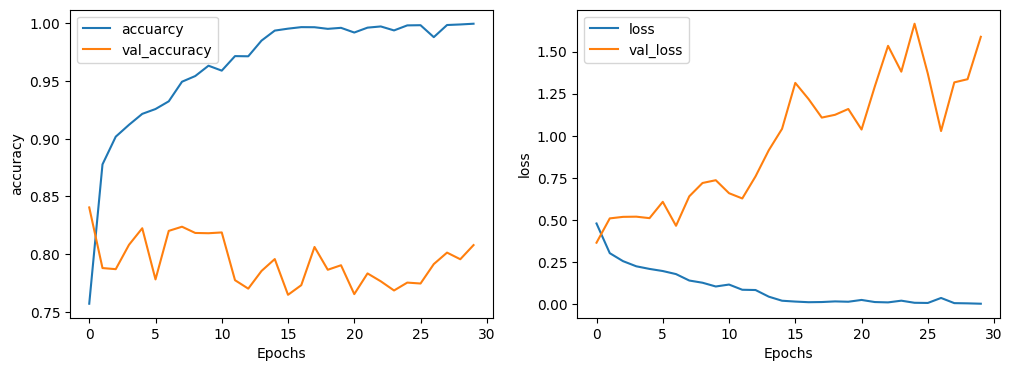

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()

In [15]:
sample_text = ['The movei was terrible. I would not recommend the movie']
# sample_text = ['The movei was fantastic. I would recommend the movie']
# sample_text = ['The animation and graphics were out of this world']
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post', truncating='post')
sample_padded

array([[  2,   1,  14, 400,  11,  64,  24, 392,   2,  18,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [16]:
model.predict([sample_padded])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(1, 150))',)
  warnings.warn(msg)


array([[0.01260108]], dtype=float32)